In [1]:
%load_ext autoreload

In [2]:
import distributed as dd
import numpy as np
import dask.array as da
import dask

from libertem.api import Context
from libertem.executor.delayed import DelayedJobExecutor
from libertem.udf.base import UDF
from libertem.udf.base import get_resources_for_backends

In [3]:
ctx = Context.make_with("dask-make-default")
# ctx = Context()
del_ctx = Context(executor=DelayedJobExecutor())

/home/weber/miniconda3/envs/ptycho38/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37921 instead
  warnings.warn(
distributed.utils - INFO - Reload module tmpkhjmlpe5 from .py file
distributed.preloading - INFO - Import preload module: /tmp/tmpkhjmlpe5.py
distributed.utils - INFO - Reload module tmppofhj1mk from .py file
distributed.utils - INFO - Reload module tmpqql4owbz from .py file
distributed.utils - INFO - Reload module tmpfyaby3ep from .py file
distributed.preloading - INFO - Import preload module: /tmp/tmppofhj1mk.py
distributed.preloading - INFO - Import preload module: /tmp/tmpqql4owbz.py
distributed.preloading - INFO - Import preload module: /tmp/tmpfyaby3ep.py
distributed.utils - INFO - Reload module tmppv5um16w from .py file
distributed.utils - INFO - Reload module tmpfto4ahpo from .py file
distributed.preloading - INFO - Import preload module: /tmp

In [4]:
class MySumUDF(UDF):
    def get_result_buffers(self):
        return {
            'intensity': self.buffer(kind='sig', dtype=self.meta.input_dtype)
        }

    def process_tile(self, tile):
        self.results.intensity[:] += np.sum(tile, axis=0)

    def merge(self, dest, src):
        dest.intensity[:] += src.intensity

In [5]:
class MySumSigUDF(UDF):
    def get_result_buffers(self):
        return {
            'intensity': self.buffer(
                kind="nav", dtype=self.meta.input_dtype
            ),
        }

    def process_tile(self, tile):
        self.results.intensity[:] += np.sum(tile, axis=tuple(range(1, len(tile.shape))))

In [8]:
ds = ctx.load('EMPAD', '/cachedata/reference/EMPAD/BiFeO3/acquisition_12.xml')
ds.set_num_cores(2)

In [9]:
res_sum = ctx.run_udf(dataset=ds, udf=MySumUDF())

In [10]:
%%timeit
res_sum = ctx.run_udf(dataset=ds, udf=MySumUDF())

131 ms ± 36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
res_sumsig = ctx.run_udf(dataset=ds, udf=MySumSigUDF())

132 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


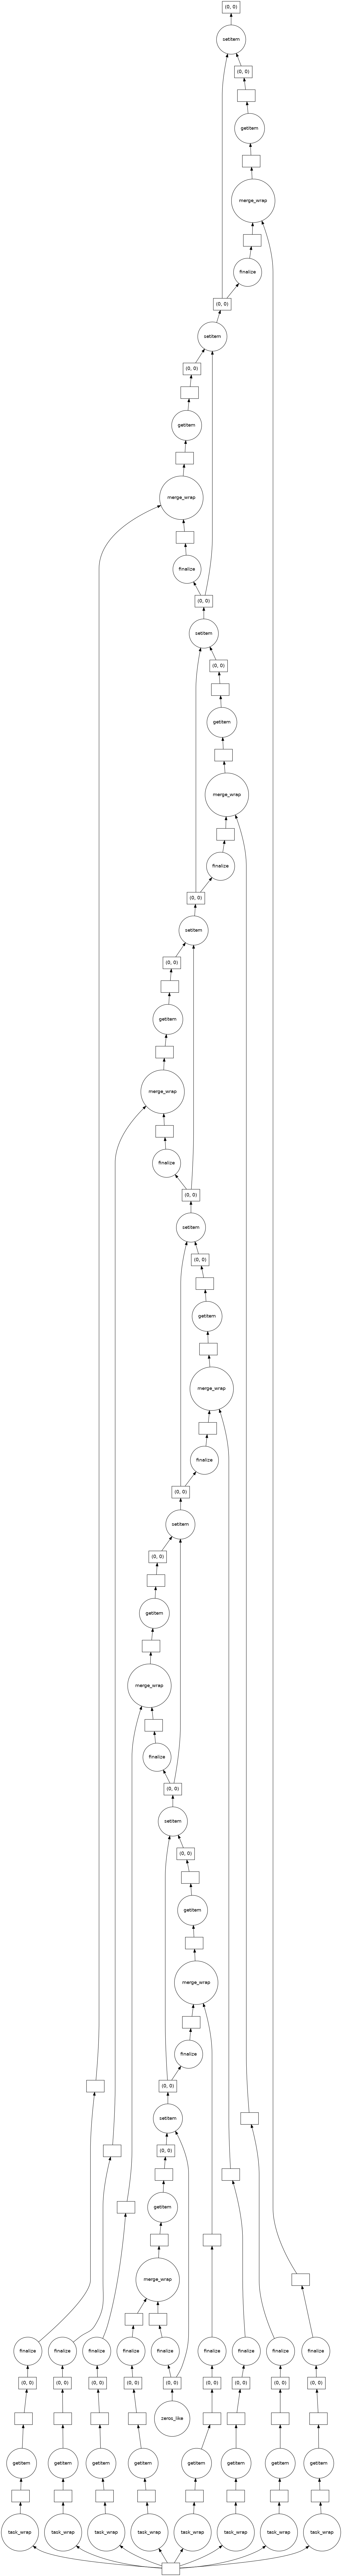

In [14]:
udf = MySumUDF()
resources = DelayedJobExecutor.get_resources_from_udfs(udf)
del_res_sum = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sum['intensity'].raw_data.visualize()

In [15]:
class MySumMergeUDF(MySumUDF):
    def dask_merge(self, ordered_results):
        intensity = np.stack([b.intensity for b in ordered_results.values()]).sum(axis=0)
        self.results.get_buffer('intensity').update_data(intensity)

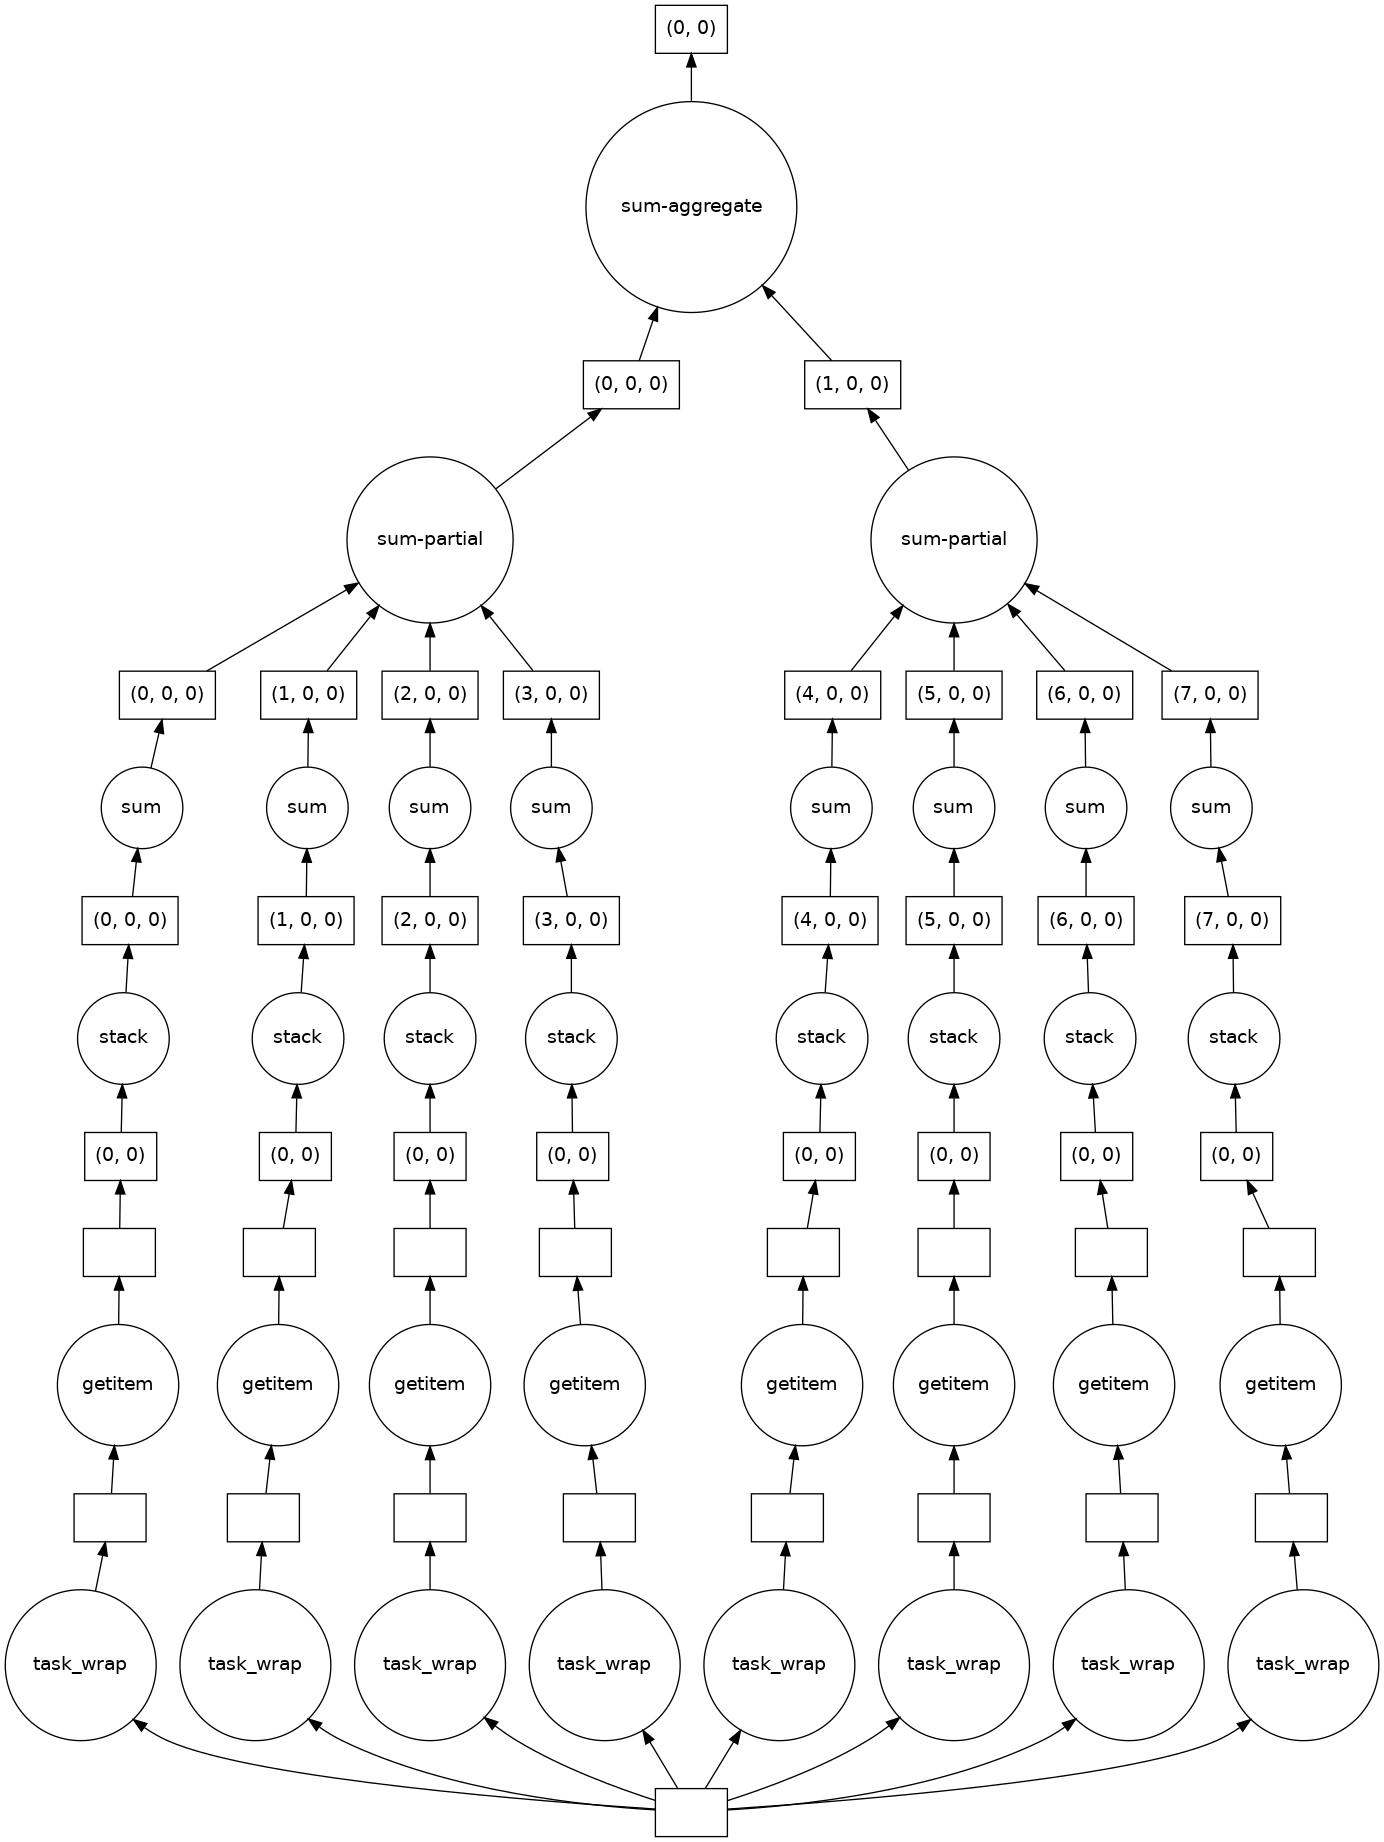

In [17]:
udf = MySumMergeUDF()
resources = DelayedJobExecutor.get_resources_from_udfs(udf)
del_res_sum = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sum['intensity'].raw_data.visualize()

In [18]:
%%timeit
udf = MySumSigUDF()
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sumsig['intensity'].raw_data.compute()

523 ms ± 85.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


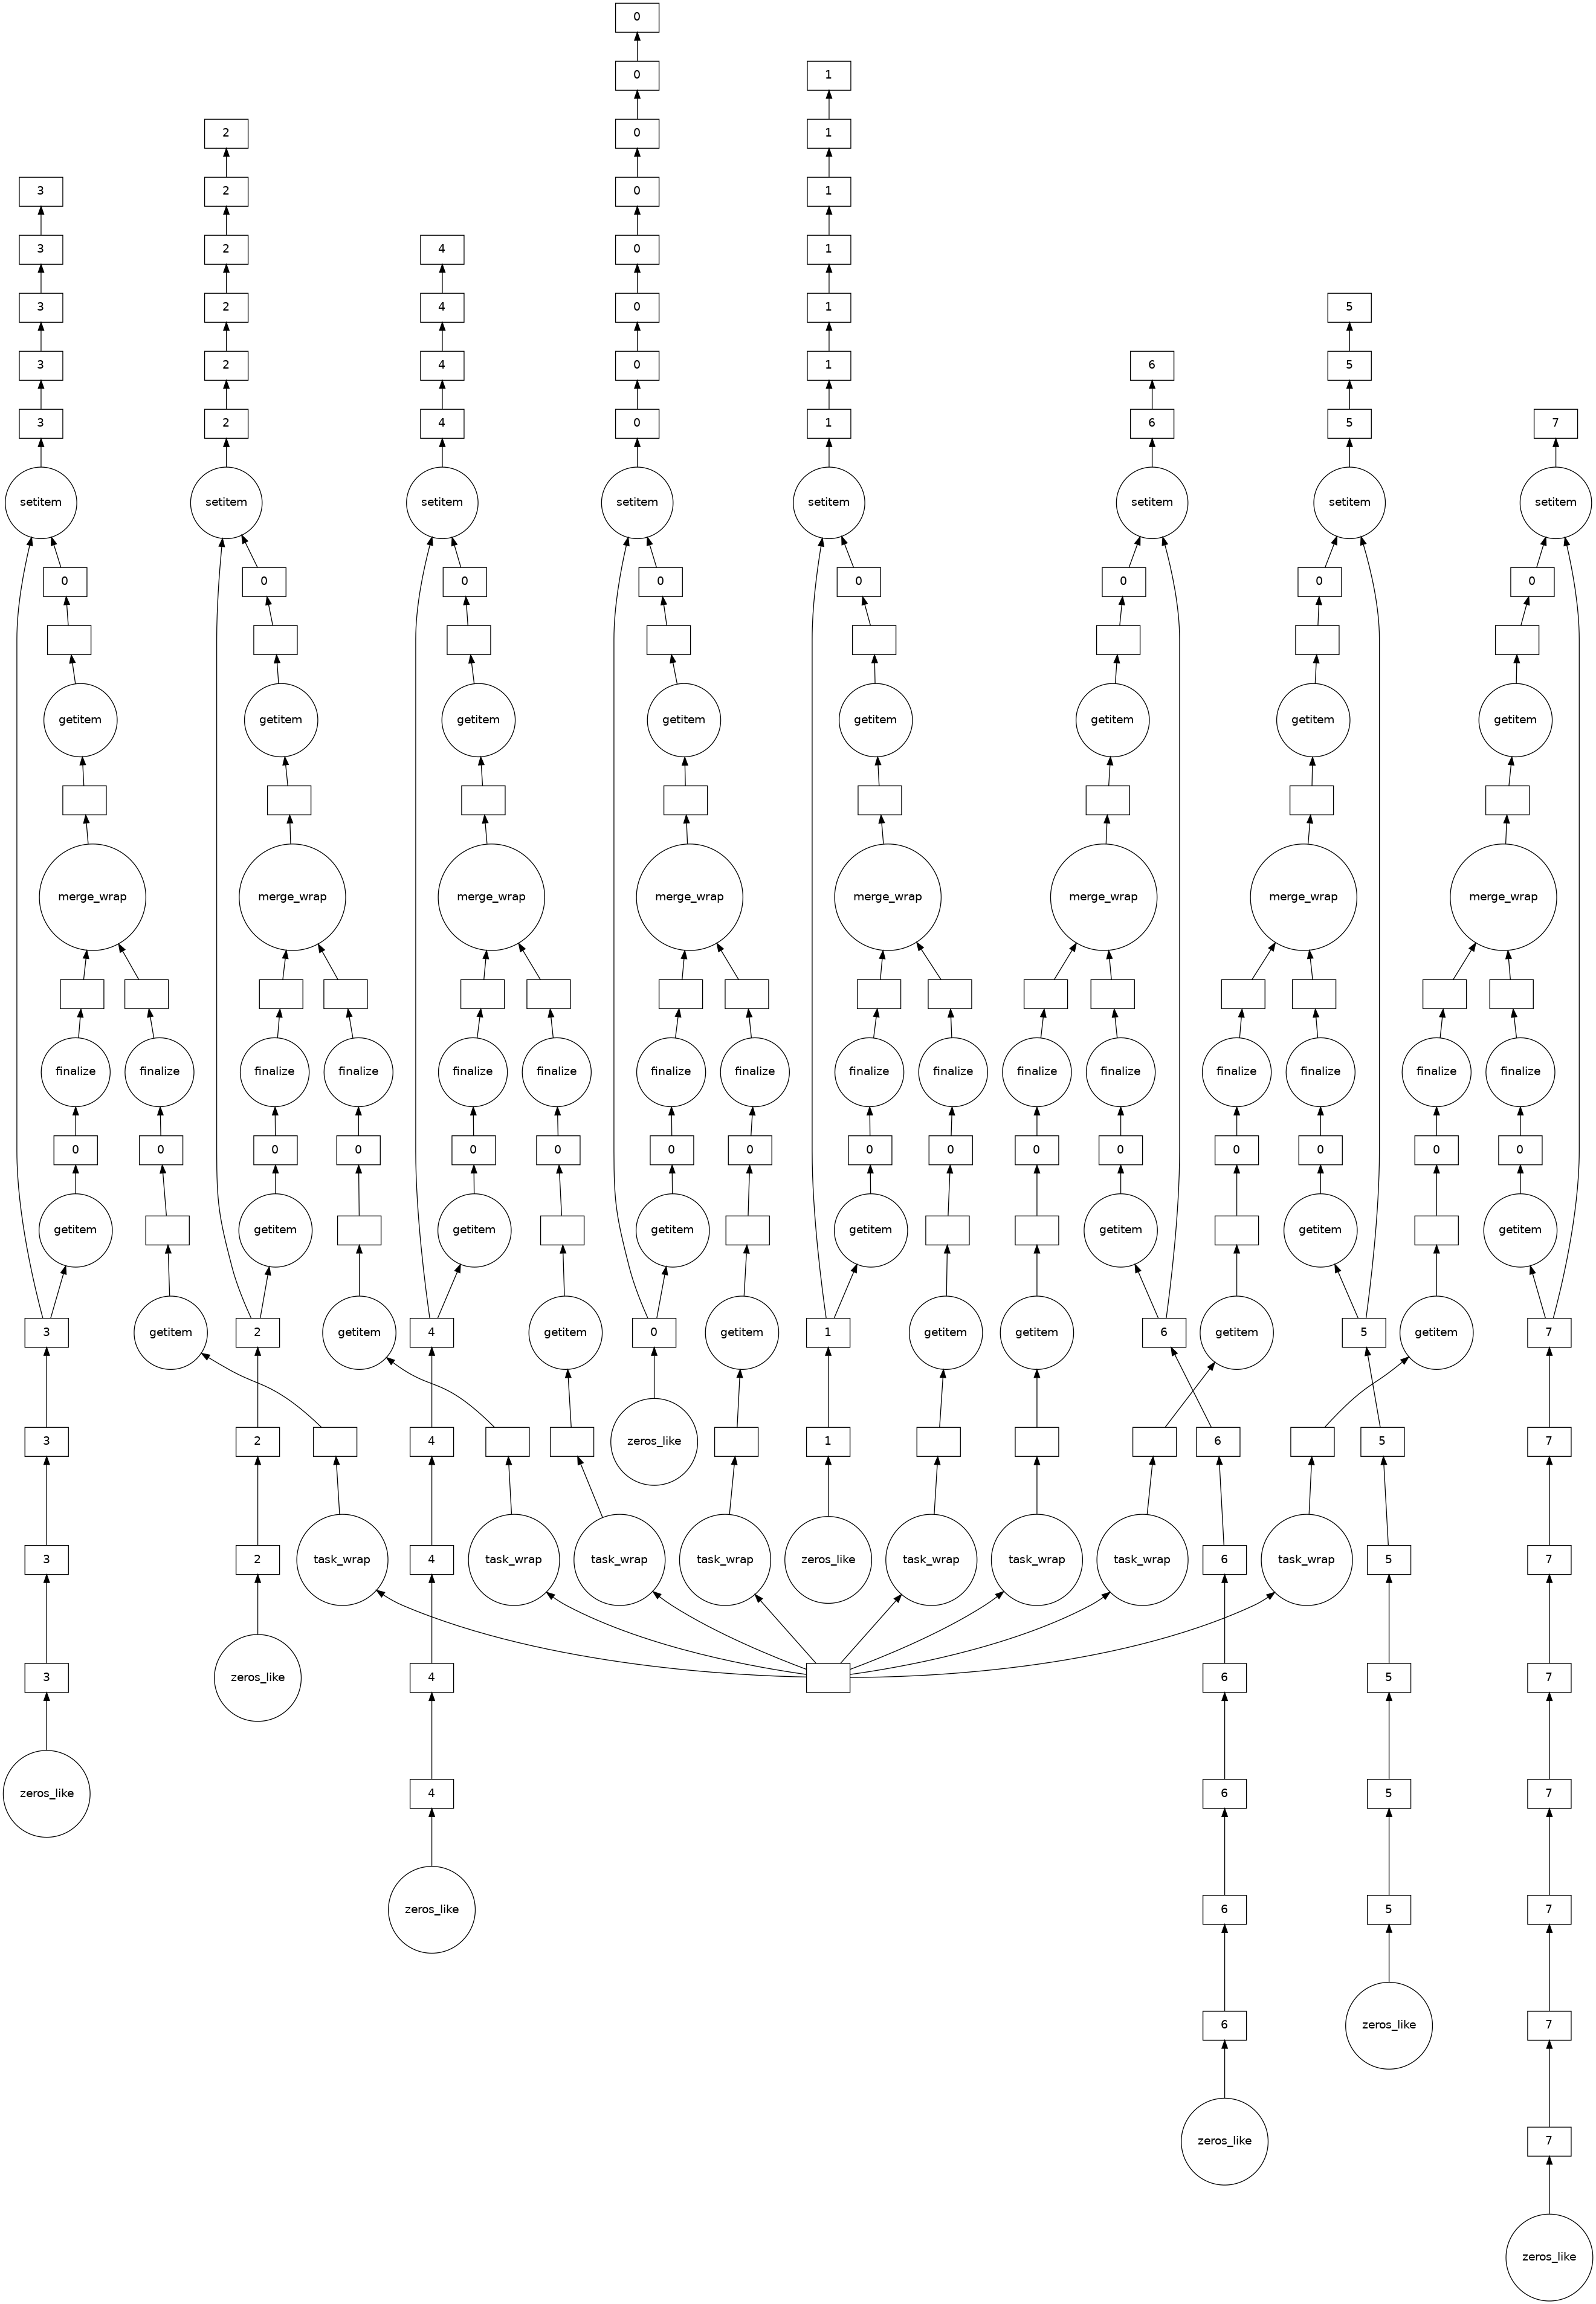

In [19]:
udf = MySumSigUDF()
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sumsig['intensity'].raw_data.visualize()


In [20]:
class MyMySumSigMergeUDF(MySumSigUDF):
    def dask_merge(self, ordered_results):
        intensity = np.concatenate([b.intensity for b in ordered_results.values()])
        self.results.get_buffer('intensity').update_data(intensity)

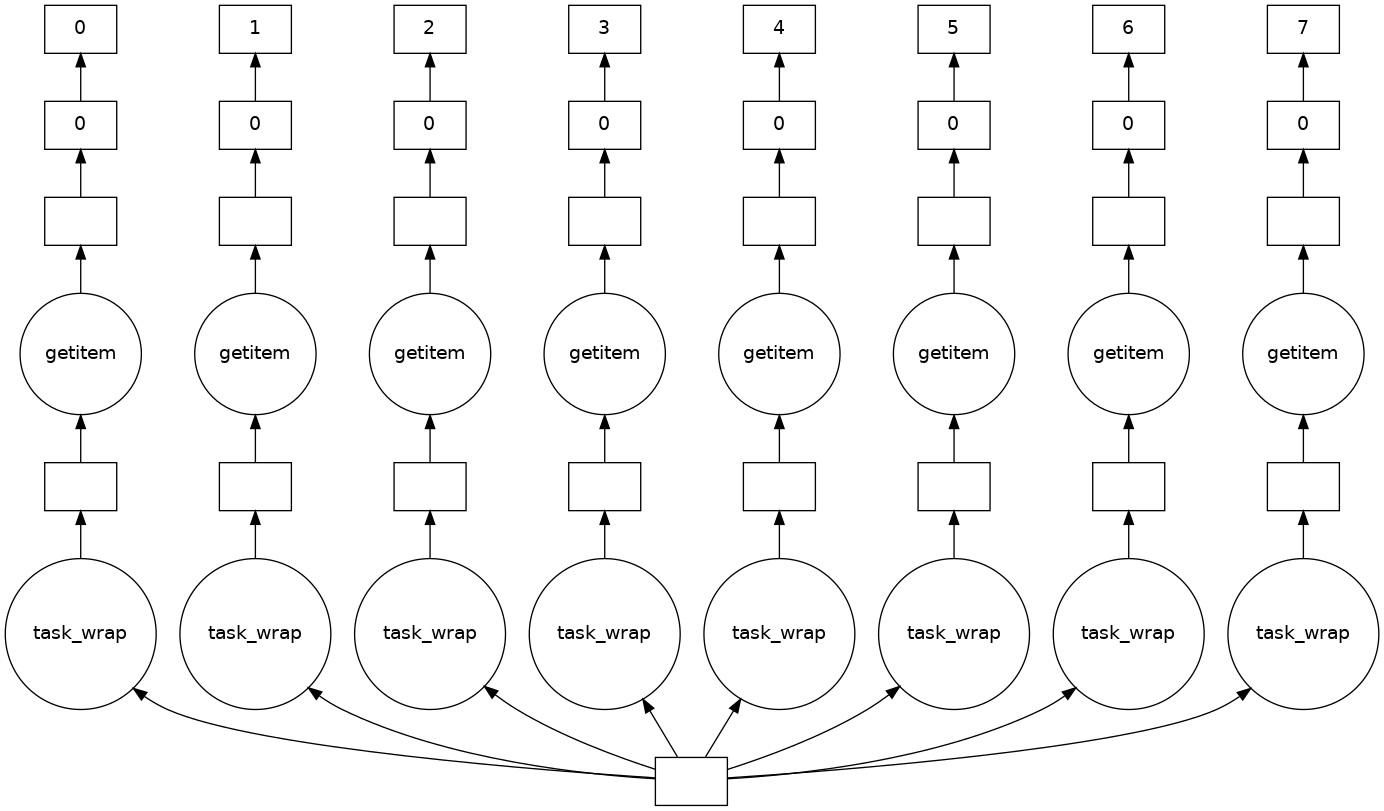

In [21]:
udf = MyMySumSigMergeUDF()
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sumsig['intensity'].raw_data.visualize()

In [22]:
%%timeit
udf = MyMySumSigMergeUDF()
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sumsig['intensity'].raw_data.compute()

206 ms ± 37.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
udf = MyMySumSigMergeUDF()
resources = DelayedJobExecutor.get_resources_from_udfs(udf)
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)

In [25]:
udf = MySumSigUDF()
resources = DelayedJobExecutor.get_resources_from_udfs(udf)
del_res_sumsig_merge = del_ctx.run_udf(dataset=ds, udf=udf)

In [26]:
dask.compute(del_res_sumsig, del_res_sumsig_merge)

({'intensity': <DaskBufferWrapper kind=nav extra_shape=() backing=dask.array<concatenate, shape=(65536,), dtype=float32, chunksize=(8192,), chunktype=numpy.ndarray>>},
 {'intensity': <DaskBufferWrapper kind=nav extra_shape=() backing=dask.array<setitem, shape=(65536,), dtype=float32, chunksize=(8192,), chunktype=numpy.ndarray>>})